# Analisis exploratorio

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

from pytorch_common.util import LoggerBuilder

import numpy as np
import pandas as pd

from data.missing import MissingsManager
import data as dt
import data.plot as pl
import util as ut

import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

In [3]:
LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

## Carga de dataset

1. Importamos los archivos de peliculas y ratings preprocesados previamente en mongodb:

In [4]:
DATASETS_PATH   = '../datasets'

movies          = pd.read_json(f'{DATASETS_PATH}/movies_v4.json')
interactions    = pd.read_json(f'{DATASETS_PATH}/ratings_tags_v1.json')

In [5]:
interactions = interactions.drop('_id', axis=1)


movies['id']  = movies['_id']
movies  = movies.drop(['_id', 'tmdb_id', 'imdb_id'], axis=1)
movies['release'] = pd.to_datetime(movies['release'], format='%Y-%m-%d')

In [6]:
interactions.dtypes

rating              float64
timestamp    datetime64[ns]
user_id               int64
movie_id              int64
tags                 object
dtype: object

In [7]:
movies.dtypes

title                        object
genres                       object
for_adults                   object
budget                        int64
original_language            object
overview                     object
poster                       object
release              datetime64[ns]
popularity                  float64
vote_mean                   float64
vote_count                  float64
tags                         object
id                            int64
dtype: object

In [8]:
interactions.head()

,rating,timestamp,user_id,movie_id,tags
0,4.0,2015-08-13 13:23:59,3,260,"[classic, sci-fi]"
1,4.5,2019-11-16 22:33:10,4,1732,"[dark comedy, great dialogue]"
2,3.5,2019-11-16 22:30:31,4,7569,[so bad it's good]
3,5.0,2019-11-16 21:10:28,4,44665,[unreliable narrators]
4,5.0,2019-11-16 21:07:21,4,115713,"[artificial intelligence, philosophical, tense]"


In [9]:
movies.head()

,title,genres,for_adults,budget,original_language,overview,poster,release,popularity,vote_mean,vote_count,tags,id
0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",False,30000000,en,"Led by Woody, Andy's toys live happily in his ...",/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,21.946943,7.7,5415.0,"[2009 reissue in stereoscopic 3-d, 3d, 55 movi...",1
1,Jumanji,"[Adventure, Children, Fantasy]",False,65000000,en,When siblings Judy and Peter discover an encha...,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,1995-12-15,17.015539,6.9,2413.0,"[adaptation of book, adapted from:book, advent...",2
2,Sabrina,"[Comedy, Romance]",False,58000000,en,An ugly duckling having undergone a remarkable...,/jQh15y5YB7bWz1NtffNZmRw0s9D.jpg,1995-12-15,6.677277,6.2,141.0,"[as good maybe better than original, based on ...",7
3,Waiting to Exhale,"[Comedy, Drama, Romance]",False,16000000,en,"Cheated on, mistreated and stepped on, the wom...",/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,1995-12-22,3.859495,6.1,34.0,"[based on novel or book, characters, chick fli...",4
4,Father of the Bride Part II,[Comedy],False,0,en,Just when George Banks has recovered from his ...,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,8.387519,5.7,173.0,"[aging, baby, clv, comedy, confidence, contrac...",5


## Valores faltantes

### Movies

Configuramos un instancia de **MissingsManager** con reglas que toman los ceros como valores faltantes para la variable budget, vote_mean y vote_count.

In [10]:
mm = MissingsManager() \
    .add_rule_fn('popularity', lambda v: v <= 0) \
    .add_rule_fn('budget', lambda v: v <= 0) \
    .add_rule_fn('vote_mean', lambda v: v <= 0) \
    .add_rule_fn('vote_count', lambda v: v <= 0)

movies.pipe(mm.report)

,Column,Percent (%),Count,rule,indexes
0,budget,0.772227,27143,CustomMissingFnRule,"[4, 8, 10, 11, 14, 15, 17, 18, 21, 25, 26, 27,..."
1,poster,0.000085,3,ColumnMissingValueRule,"[17450, 24442, 28570]"
2,release,0.000854,30,ColumnMissingValueRule,"[15236, 15316, 17450, 17676, 20298, 22988, 244..."
3,popularity,0.000541,19,CustomMissingFnRule,"[5357, 15236, 17676, 17786, 18100, 18806, 2302..."
4,vote_mean,0.048024,1688,CustomMissingFnRule,"[100, 123, 126, 151, 363, 365, 378, 539, 545, ..."
5,vote_count,0.045833,1611,CustomMissingFnRule,"[100, 123, 126, 151, 363, 365, 378, 545, 547, ..."


Removemos las filas del dataset para aquellas columnas del reporte de valores faltantes que tengan una cantida de hasta 0.06 % de valores faltantes:

In [11]:
movies2 = movies.pipe(mm.remove_rows, max_missings=0.06)

2022-07-17 17:03:37,817 - INFO - Remove rows for columns <= 0.06 % of missings values.


In [12]:
movies2.pipe(mm.report)

,Column,Percent (%),Count,rule,indexes
0,budget,0.762289,25494,CustomMissingFnRule,"[4, 8, 10, 11, 14, 15, 17, 18, 21, 25, 26, 27,..."


De esta forma, borramos todas las filas con missing values en columnas con un porcentaje de missing <= 0.06, quedandonos solamente una columna con un porcentaje mayor de missing values. Esta columna no se puede utilizar en el entrenamiento, ya que tiene 70% de missing values. Por esta cuestion optamos por removerla del dataset.

In [13]:
movies3 = movies2.pipe(mm.remove_columns, max_percent=0.4)

2022-07-17 17:03:38,111 - INFO - Remove columns with missing >= 0.4 %


In [14]:
movies3.pipe(mm.report)

,Column
0,Not found columns with missing values


Finalemente obtenemos un dataset sin missings.

In [15]:
movies3.head()

,title,genres,for_adults,original_language,overview,poster,release,popularity,vote_mean,vote_count,tags,id
0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",False,en,"Led by Woody, Andy's toys live happily in his ...",/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,1995-10-30,21.946943,7.7,5415.0,"[2009 reissue in stereoscopic 3-d, 3d, 55 movi...",1
1,Jumanji,"[Adventure, Children, Fantasy]",False,en,When siblings Judy and Peter discover an encha...,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,1995-12-15,17.015539,6.9,2413.0,"[adaptation of book, adapted from:book, advent...",2
2,Sabrina,"[Comedy, Romance]",False,en,An ugly duckling having undergone a remarkable...,/jQh15y5YB7bWz1NtffNZmRw0s9D.jpg,1995-12-15,6.677277,6.2,141.0,"[as good maybe better than original, based on ...",7
3,Waiting to Exhale,"[Comedy, Drama, Romance]",False,en,"Cheated on, mistreated and stepped on, the wom...",/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,1995-12-22,3.859495,6.1,34.0,"[based on novel or book, characters, chick fli...",4
4,Father of the Bride Part II,[Comedy],False,en,Just when George Banks has recovered from his ...,/e64sOI48hQXyru7naBFyssKFxVd.jpg,1995-02-10,8.387519,5.7,173.0,"[aging, baby, clv, comedy, confidence, contrac...",5


In [16]:
movie_missings_percent = 1 - (len(movies3) / len(movies))

print(f'El porcentaje filas con valores faltantes en la tabla movies es del {movie_missings_percent:.2f} %')

El porcentaje filas con valores faltantes en la tabla movies es del 0.05 %

### Interactions

In [17]:
mm = MissingsManager() \
    .add_rule_fn('tags', lambda v: len(v) == 0) \
    .add_rule_fn('rating', lambda v: v < 0.5)

interactions.pipe(mm.report)

,Column
0,Not found columns with missing values


Renombramos la tabla ratings como interactions, ya que esta representa la acción que realiza un usuario al clasificar una pelicula. Ademas, se registra el momento del evento y por otro lado tenemos los tags que cargo el mismo usaurio a la pelicula pelicula clasificada. 

Para chequear faltantes agregarmos dos reglas extra:

- Si la columna tags no tiene valores (Cada valor es una colección), se toma con un valor faltante.
- Si tenemos ratings menores a 0.5, los tomamos con un valor faltante.

Finalmente, se peude aprecia que el reporte de missing values no muestra columnas con valores faltantes.

## ¿Con que número de peliculas y usuarios contamos?

**Peliculas:**

In [18]:
len(np.unique(movies3.id.values))

33444

**Usuarios que calificaron peliculas**: No es lo mismo que el total de usuarios. Esto son los usuarios quw al menos calificaron una pelicula.

In [19]:
len(np.unique(interactions.user_id.values))

13281

**Cantidad de peliculas calificadas por al menos un usuario:**

In [20]:
len(np.unique(interactions.movie_id.values))

22082

## Variables

A continacion analizamos cada variable en ambas tablas.

### Movies

A continaución analizamos cada variable de la tabla movies.

In [21]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35149 entries, 0 to 35148
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              35149 non-null  object        
 1   genres             35149 non-null  object        
 2   for_adults         35149 non-null  object        
 3   budget             35149 non-null  int64         
 4   original_language  35149 non-null  object        
 5   overview           35149 non-null  object        
 6   poster             35146 non-null  object        
 7   release            35119 non-null  datetime64[ns]
 8   popularity         35146 non-null  float64       
 9   vote_mean          35146 non-null  float64       
 10  vote_count         35146 non-null  float64       
 11  tags               35149 non-null  object        
 12  id                 35149 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory 

<Figure size 792x648 with 2 Axes>

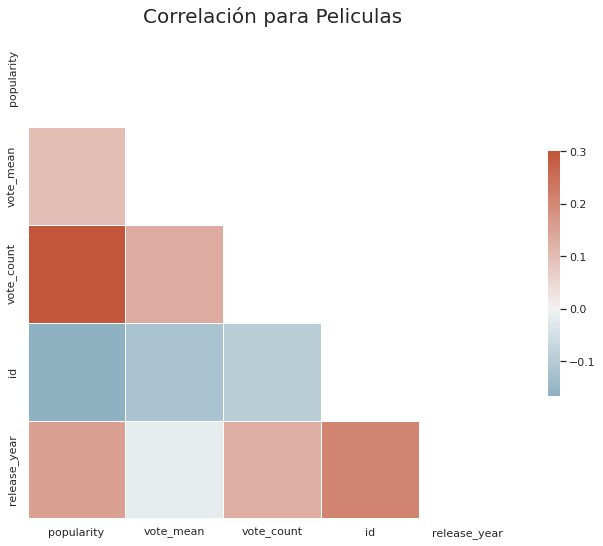

In [22]:
pl.correlations(
    movies3, 
    title='Correlación para Peliculas'
)

#### Popilarity

<Figure size 1080x576 with 2 Axes>

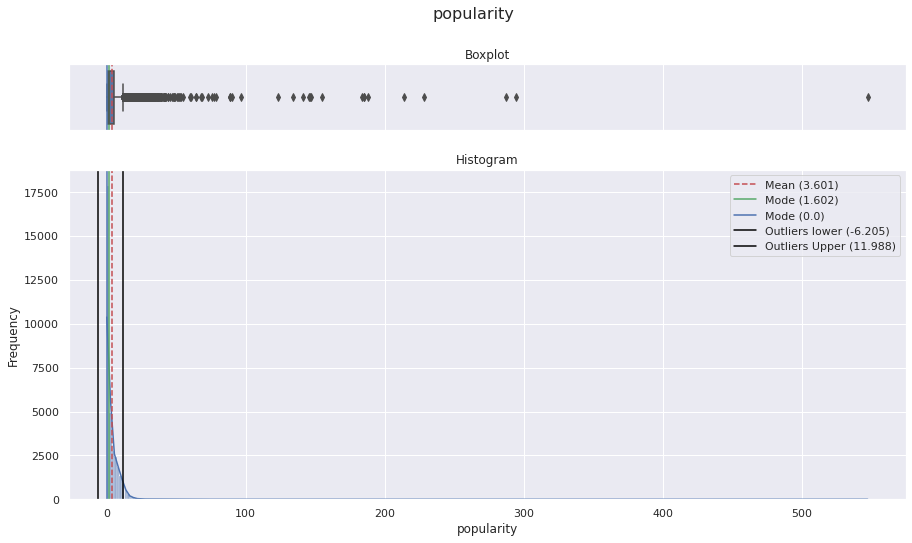

In [23]:
pl.l_size()
pl.describe_num_var(movies3, "popularity", bins=300)

<Figure size 1080x576 with 2 Axes>

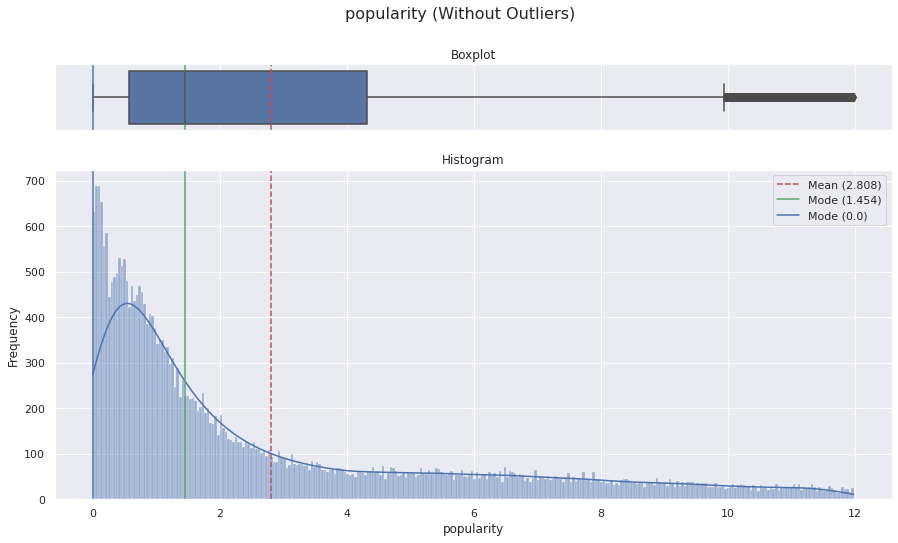

In [24]:
pl.describe_num_var(movies3, "popularity", bins=300, remove_outliers=True)

**Observaciones**

* La popularidad mantiene la relación de una ley de potencias, donde pocas peliculas son muy populares siendo en su mayoria valores atipicos, por encima de bigote superior o maximo y muchas peliculas tiene valores bajs de popularidad.
* Si quitams todos los valores > Q3+1.5*IQR y < Q1-1.5*IQR vemos con mas claridad una distribucion sesgadda a derecha y por ende la mediana y media a izquierda.
* La mode se encuetra en el cero. Esto nos dice que la mayoria de peliculas tiene popularidad cero.

### For Adults

¿La pelicula esta catalogada para mayores de edad? 

<Figure size 360x360 with 1 Axes>

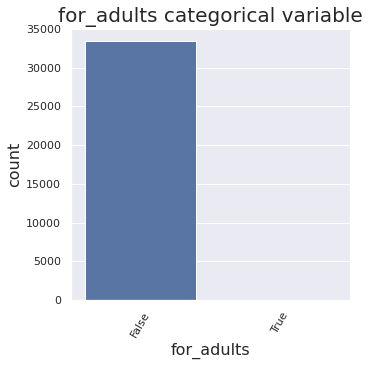

In [25]:
pl.s_size()
pl.describe_cat_var(movies3, "for_adults")

**Observaciones**

* Se aprecia que esta variable esta muy desbalanceada. 
* Ademas es inconsistente, ya que de 33.444 peliculas solo 6 son para adultos. Por esta cuestión esta columna no es apto para el entrenamiento y se decidio removerla.

### Release

Se refiere a la fecha de estreno de la pelicula.

In [26]:
movies3['release_year'] = movies3.release.dt.year

In [27]:
movies3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33444 entries, 0 to 35148
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              33444 non-null  object        
 1   genres             33444 non-null  object        
 2   for_adults         33444 non-null  object        
 3   original_language  33444 non-null  object        
 4   overview           33444 non-null  object        
 5   poster             33444 non-null  object        
 6   release            33444 non-null  datetime64[ns]
 7   popularity         33444 non-null  float64       
 8   vote_mean          33444 non-null  float64       
 9   vote_count         33444 non-null  float64       
 10  tags               33444 non-null  object        
 11  id                 33444 non-null  int64         
 12  release_year       33444 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(7)
memory 

<Figure size 2160x1080 with 1 Axes>

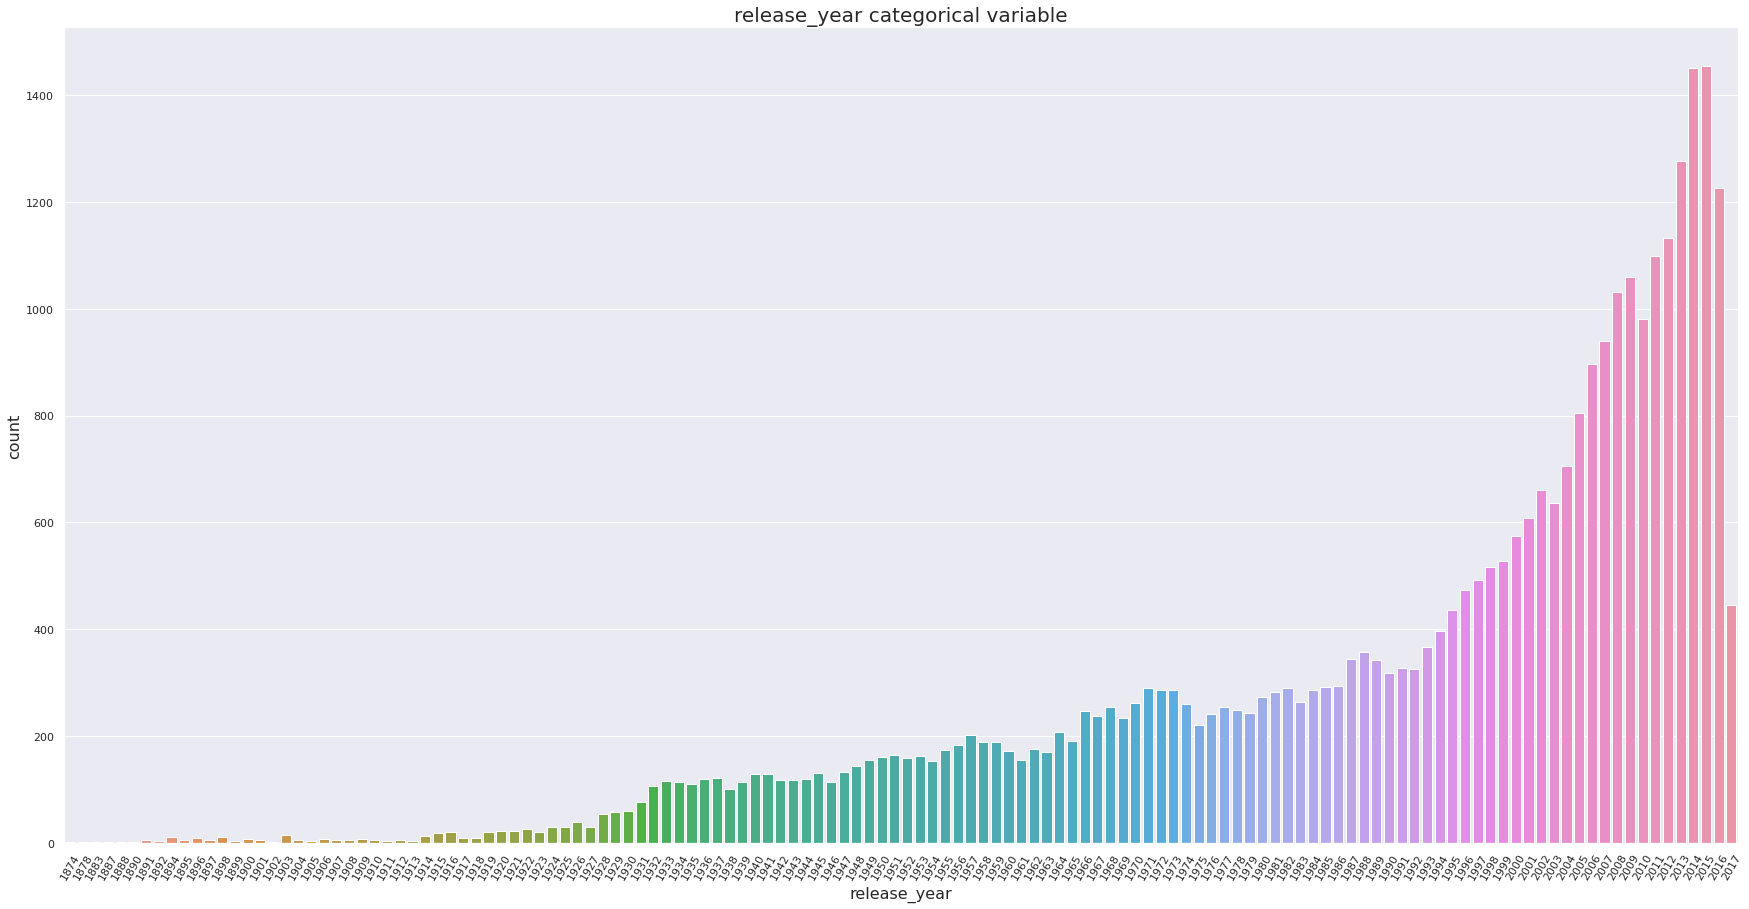

In [28]:
pl.xxl_size()
pl.describe_cat_var(movies3, 'release_year', order_column='release_year')

**Observaciones**

* Acalramos que hay una icinsitencia de datos. Hay años como 2005 donde el primero de enero tiene todos los estrenso de año y otros deonde los estrenos estan repartidos en varias fechas. Esto nos dice que es posible que en realidad este campo represente la cantidad de pelicula extrenada por año o bien que esa sea la cardinalidad real de los datos.
* Por otro lado en el grafico se aprecia que la cantidad de peliculas estrenada por año crese exponencialmente y 2017 baja lo cual seguramente es decido a que no se encuentra todo el año.
* A partor del 1994 se aprecia in el mayor crecimiento.

### Original Language

Se refiere al lenguage del audio original de la pelicula.

<Figure size 2160x720 with 1 Axes>

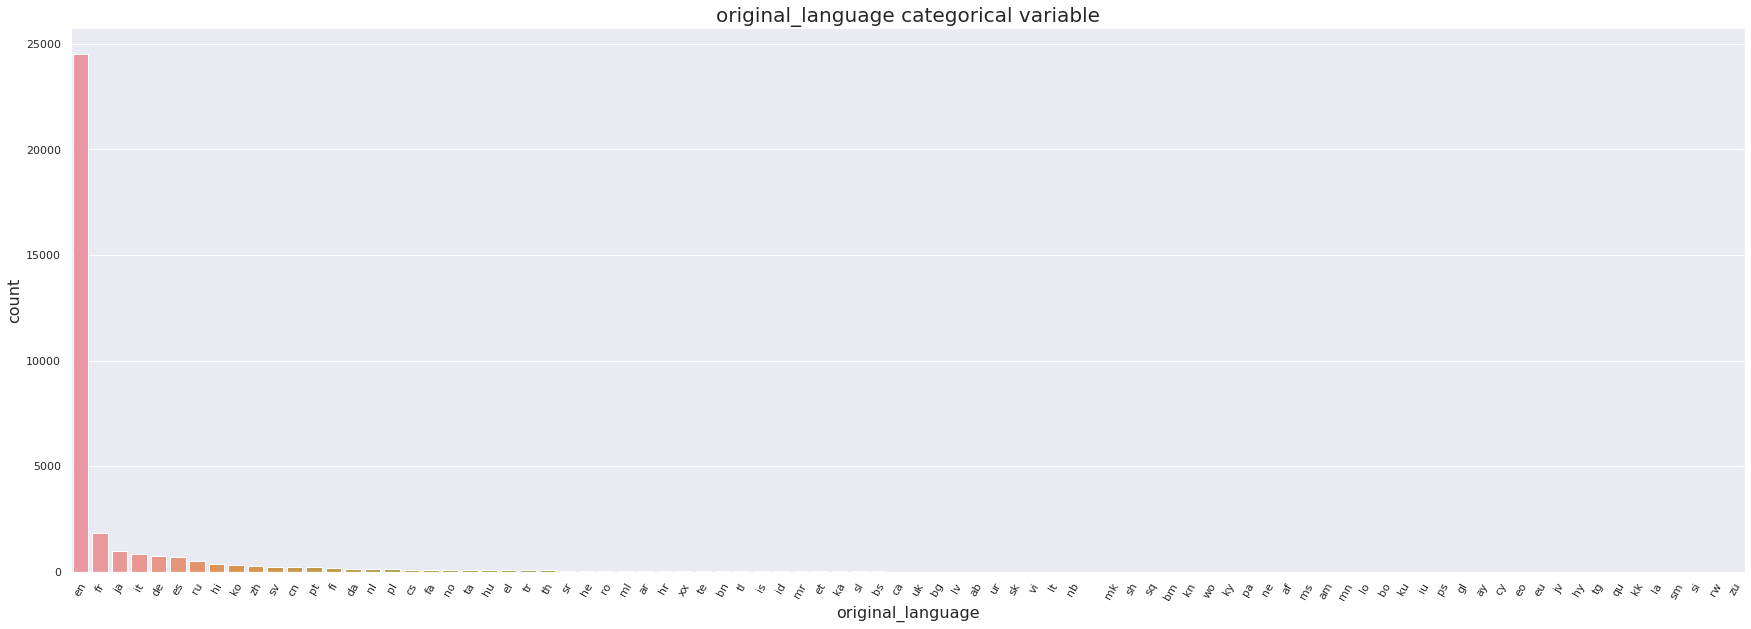

In [29]:
pl.xxl_flat_size()
pl.describe_cat_var(movies3, 'original_language')

**Observaciones**

* Es de esperar que el lenguage predominante sea el ingles.

!uitemos esta opcion y volvamos a graficas:

<Figure size 2160x720 with 1 Axes>

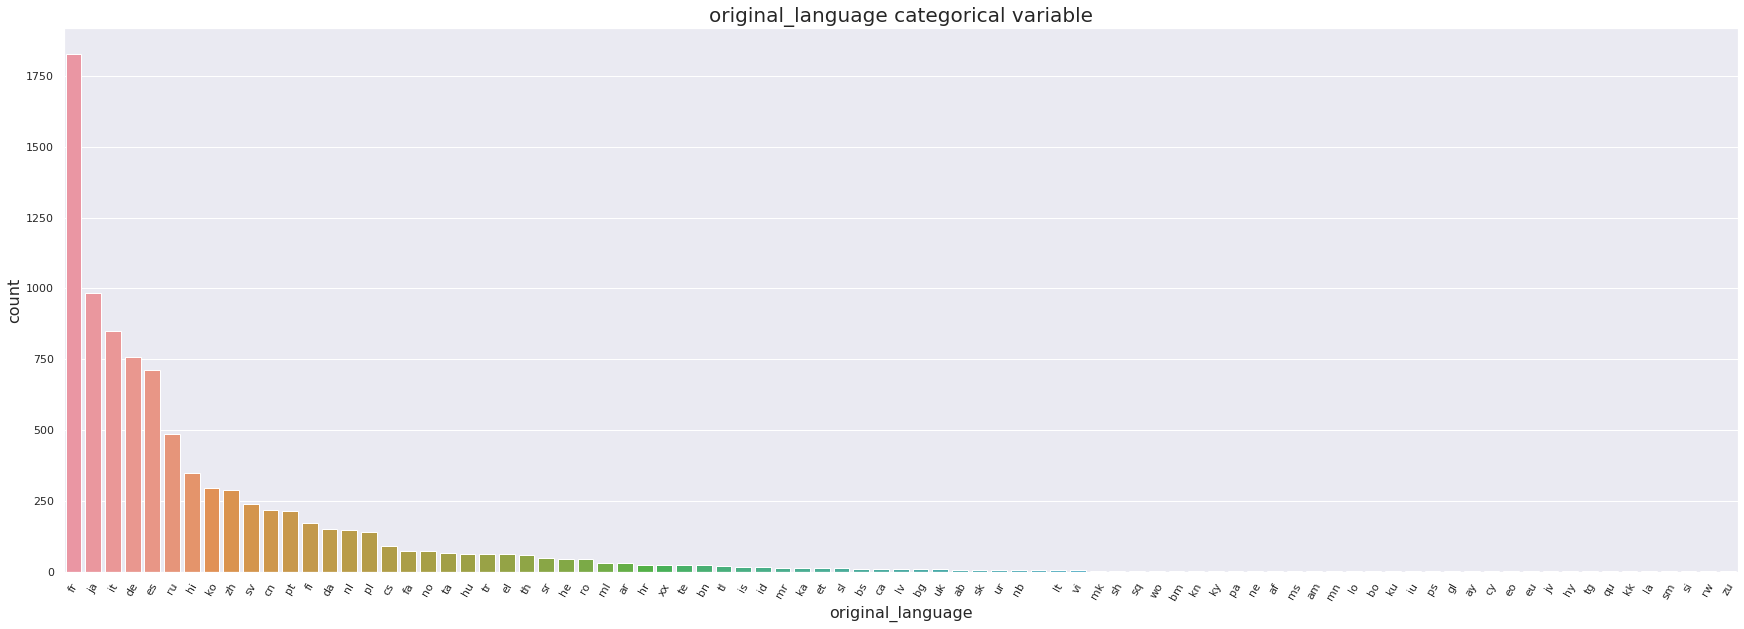

In [30]:
pl.xxl_flat_size()
pl.describe_cat_var(
    movies3[movies3['original_language'] != 'en'], 
    'original_language'
)

**Observaciones**

* Vemos que que los lenguajes frances, japones, italiana, aleman y español son los lenguages originales con mas mayor ferciencia. Eston indica indirectamente que son los paises con mas peso en el mundo sinematografico ademas de los paises de habla inglesa.

### Cantidad de votos

Representa la cantidad de votos o calificaciones que recibio la pelicula en el dataset en the movie database.

<Figure size 1080x288 with 2 Axes>

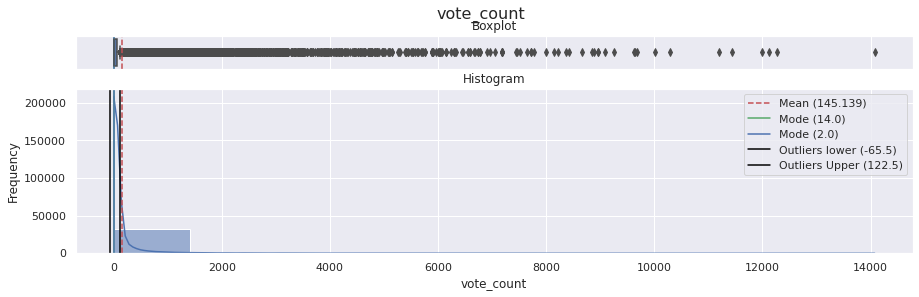

In [31]:
pl.l_flat_size()
pl.describe_num_var(movies3, "vote_count", bins=10)

<Figure size 1080x288 with 2 Axes>

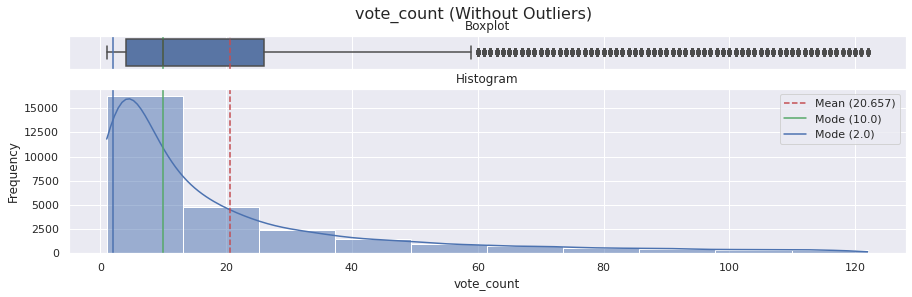

In [32]:
pl.describe_num_var(movies3, "vote_count", bins=10, remove_outliers=True)

### Tags

Esta columna tiene un conjunto sin repeticion de los tagas agragrados por todos los auaurios que calificaron una pelicula. Cada tag es una palabra o conunto de palabras. A continuacion se grafica una nube de palabras para visualiazr la freciencia relativa de las palabras que comonen los tagas:

<Figure size 2160x720 with 1 Axes>

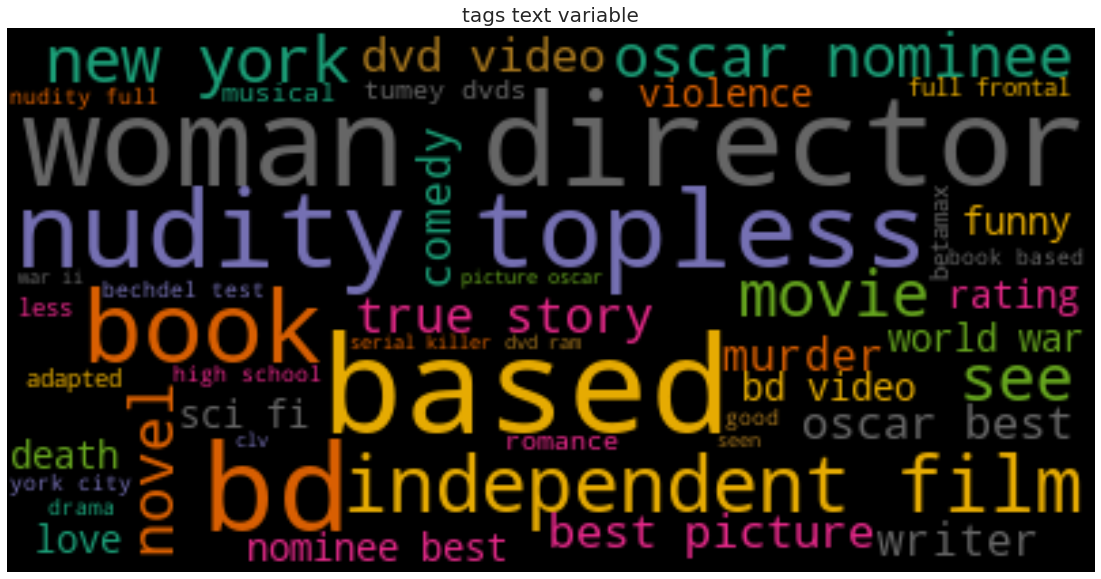

In [33]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'tags', flatten=True)

### Overview

La variable overview contiene la reseña o un resumen de la pelicula. Al igual qeu la variable tagas graficamos una nube de palabras para visualizar la freciencia relativa de las mismas:

<Figure size 2160x720 with 1 Axes>

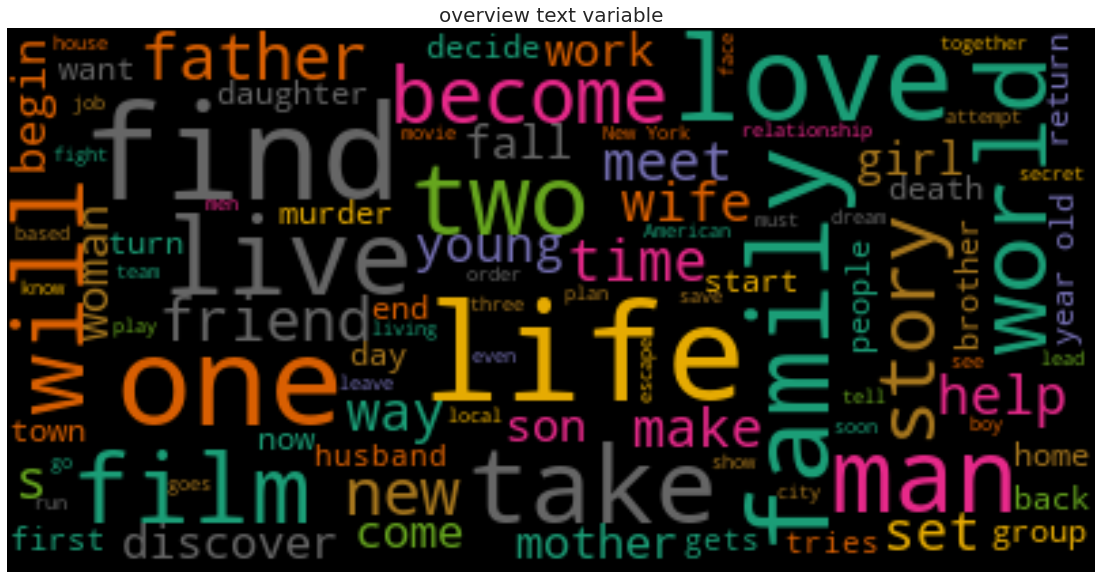

In [34]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'overview')

## Title

Esta varaible reprsenta el titulo de una pelicula. A continuacion nuevamente graficamos la frecuenia relativa de las palabar que componen todos los titulos del dataset:

<Figure size 2160x720 with 1 Axes>

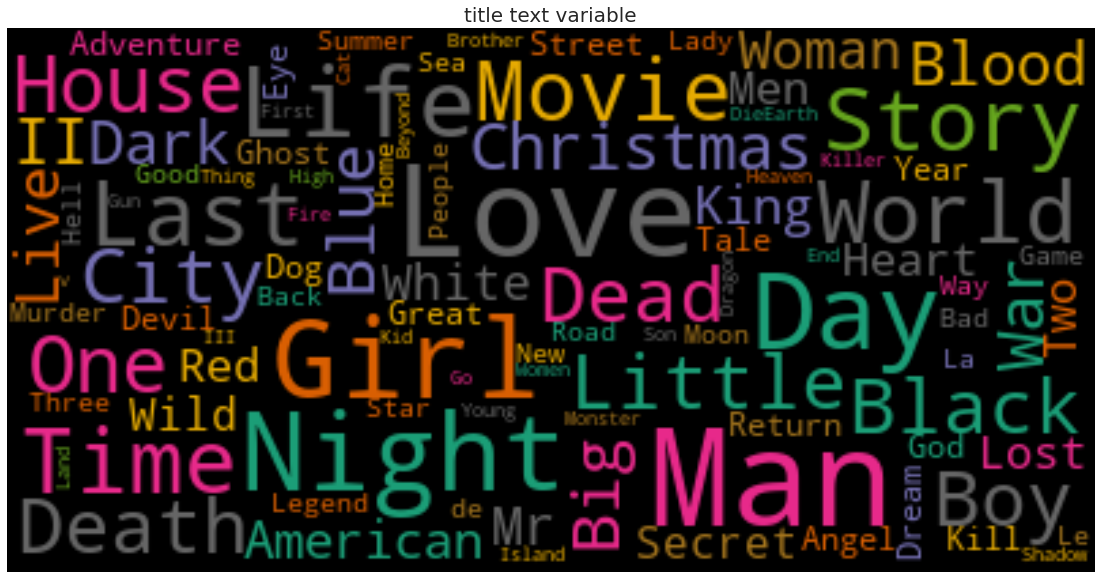

In [35]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'title')

## Interactions

<Figure size 792x648 with 2 Axes>

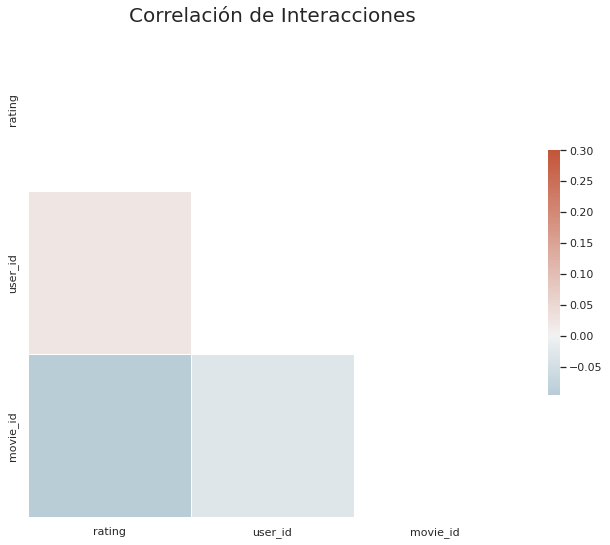

In [36]:
pl.correlations(
    interactions, 
    title='Correlación de Interacciones'
)

### Rating

In [37]:
dt.group_by(interactions, 'rating')

,rating,count
7,4.0,49438
9,5.0,37157
6,3.5,34047
8,4.5,32330
5,3.0,25186
4,2.5,11889
3,2.0,8924
2,1.5,4225
1,1.0,3923
0,0.5,3606


Veamos la distribución de la calificaciones de la peliculas realizadas por los usaurio para todo el periodo del dataset:

In [38]:
years_range = (interactions['timestamp'].min().strftime("%Y-%m"), interactions['timestamp'].max().strftime("%Y-%m"))
years_range

('1997-09', '2019-11')

<Figure size 1080x288 with 2 Axes>

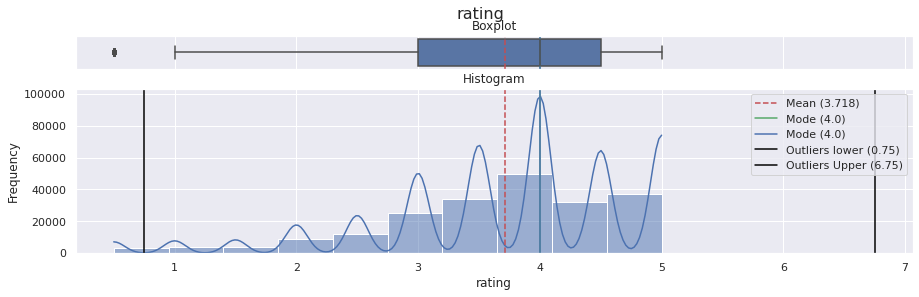

In [39]:
pl.l_flat_size()
pl.describe_num_var(interactions, "rating", bins=10)

Ahora veamos como cambia la distribucion del rating a través de los años:

<Figure size 1440x1080 with 24 Axes>

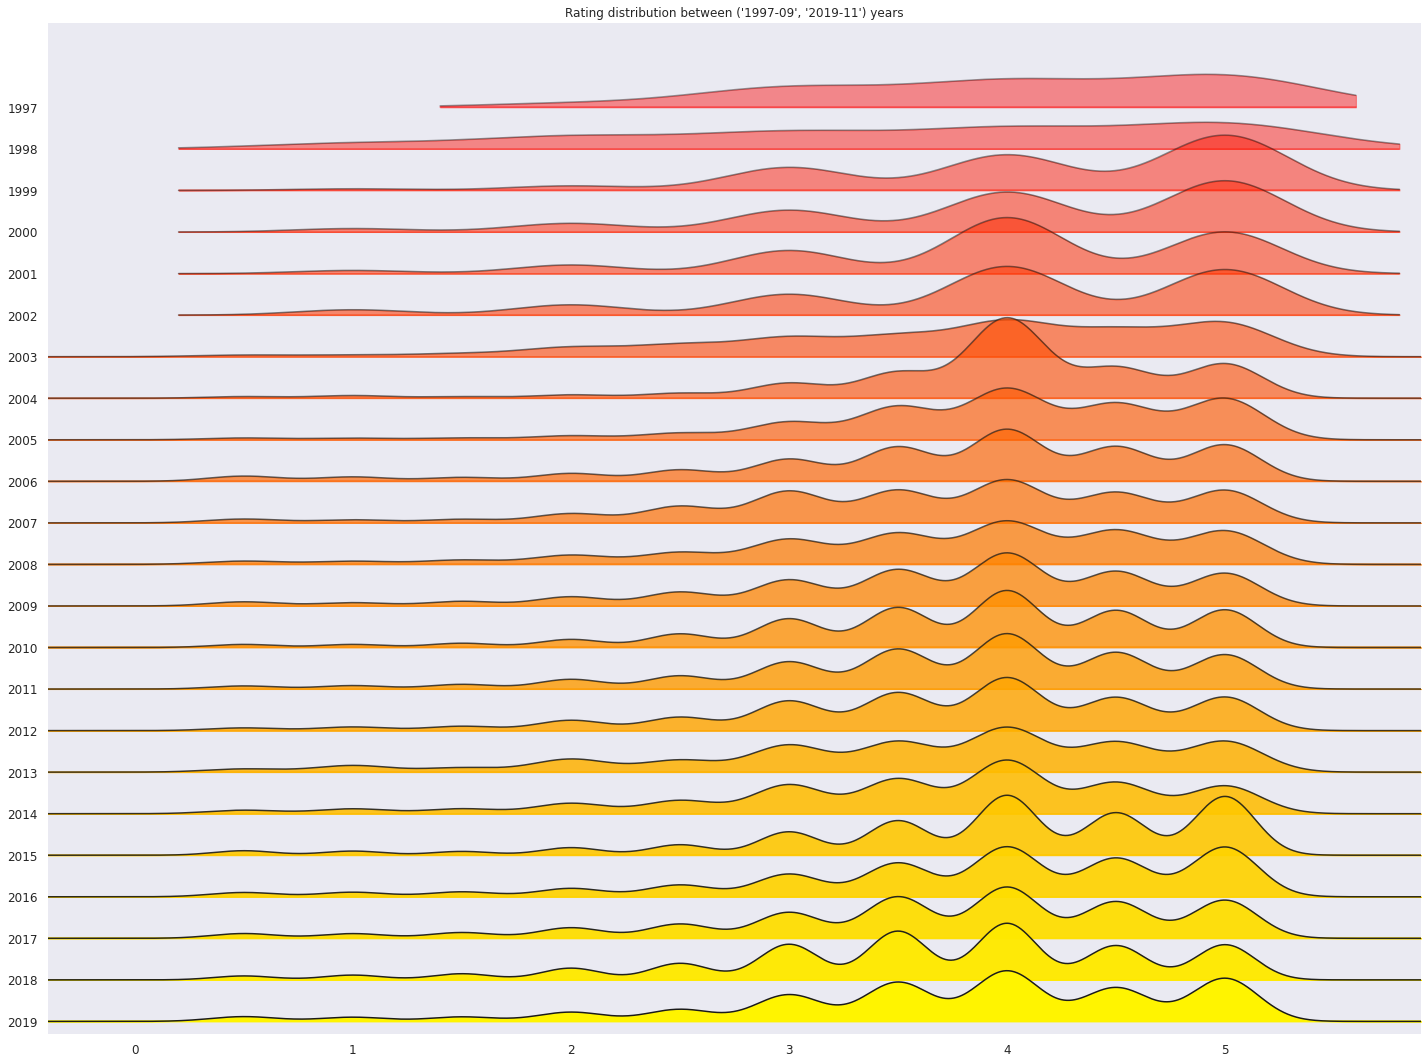

In [41]:
interactions['year'] = interactions.timestamp.dt.year

pl.xl_size()
pl.ridgeplot(interactions, by='year', column='rating', title=f'Rating distribution between {years_range} years')

# Peliculas y interacciones

# Correlaciones

In [233]:
complete_data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    )
complete_data = complete_data.loc[:, complete_data.columns!='id']


complete_num_data = complete_data \
    .select_dtypes(include=np.number)

norm_complete_num_data = ut.norm(complete_num_data)

<Figure size 792x648 with 2 Axes>

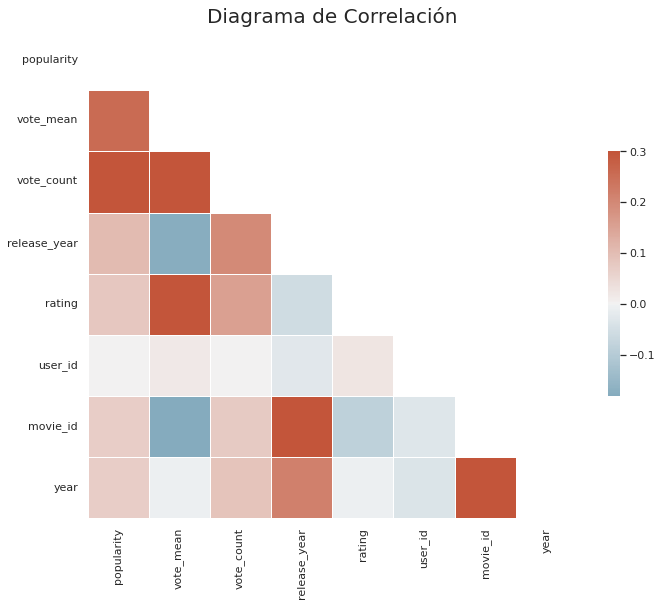

In [234]:
pl.correlations(norm_complete_num_data)

/home/adrian/.conda/envs/thesis/lib/python3.10/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<Figure size 360x360 with 1 Axes>

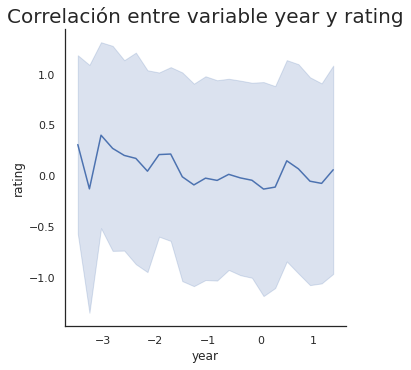

<Figure size 360x360 with 1 Axes>

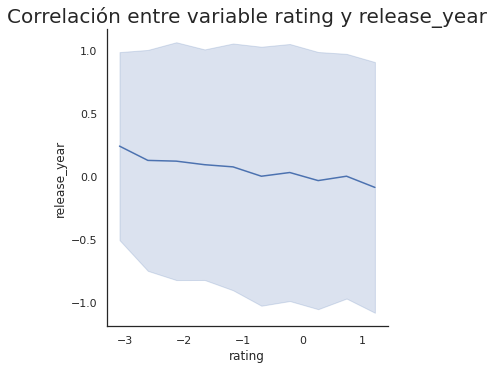

<Figure size 360x360 with 1 Axes>

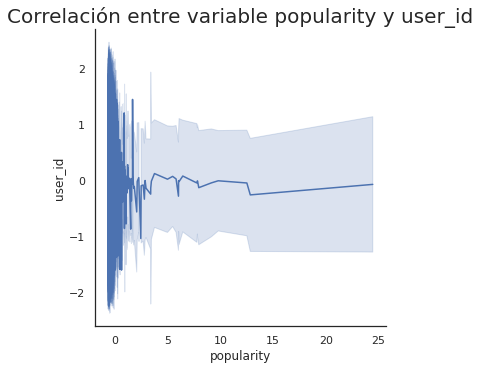

<Figure size 360x360 with 1 Axes>

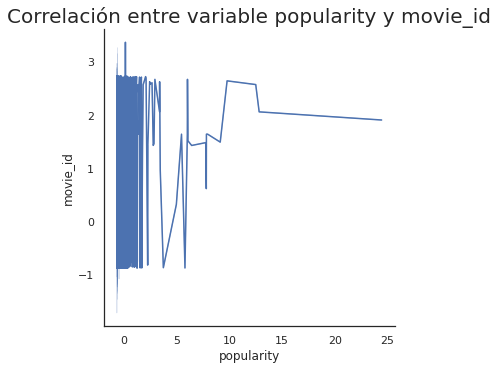

<Figure size 360x360 with 1 Axes>

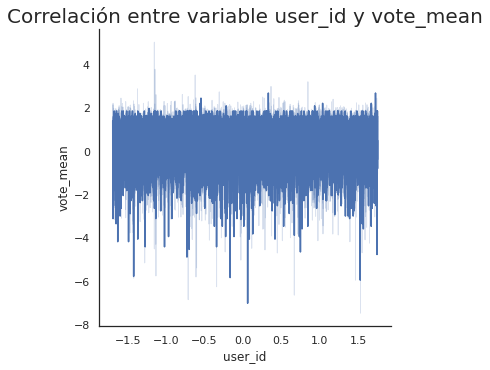

<Figure size 360x360 with 1 Axes>

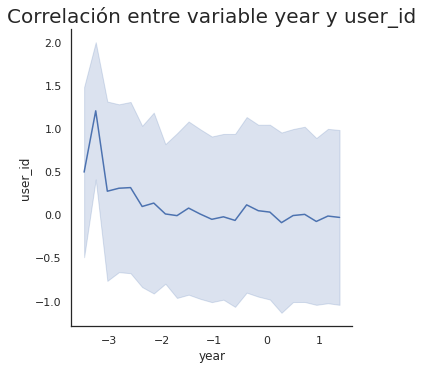

<Figure size 360x360 with 1 Axes>

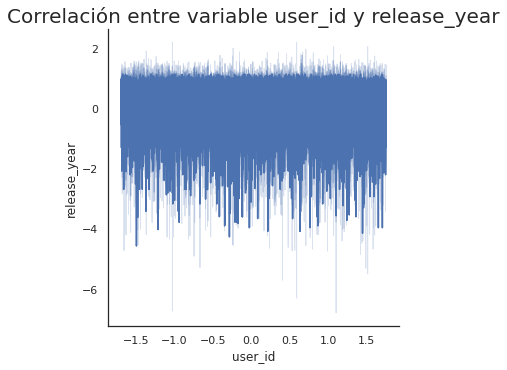

<Figure size 360x360 with 1 Axes>

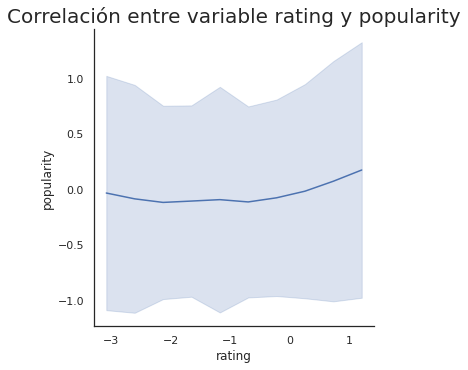

<Figure size 360x360 with 1 Axes>

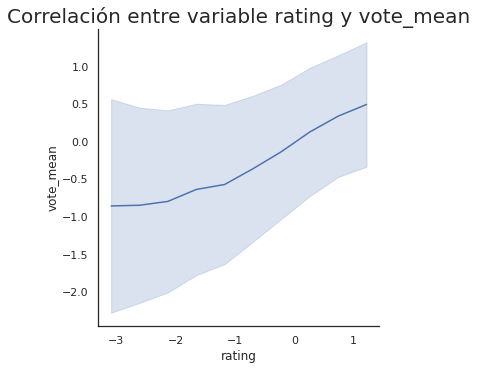

<Figure size 360x360 with 1 Axes>

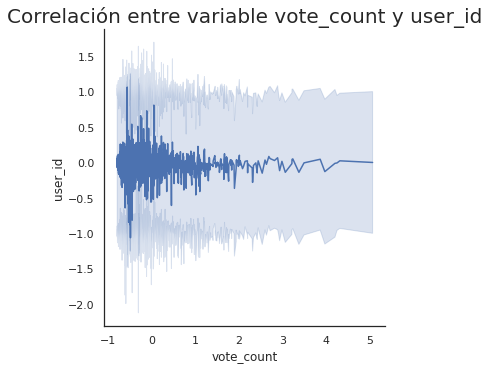

<Figure size 360x360 with 1 Axes>

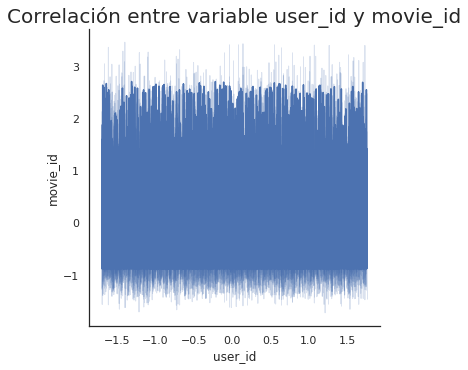

<Figure size 360x360 with 1 Axes>

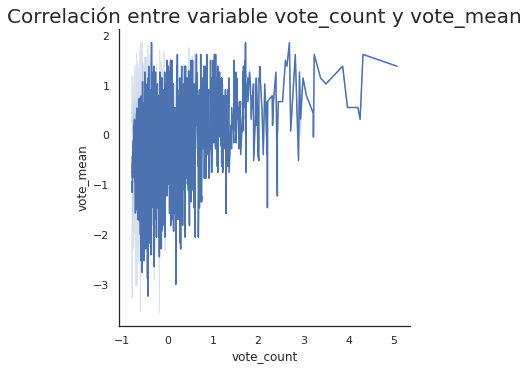

<Figure size 360x360 with 1 Axes>

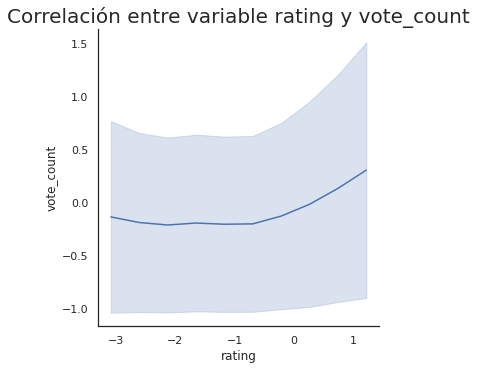

<Figure size 360x360 with 1 Axes>

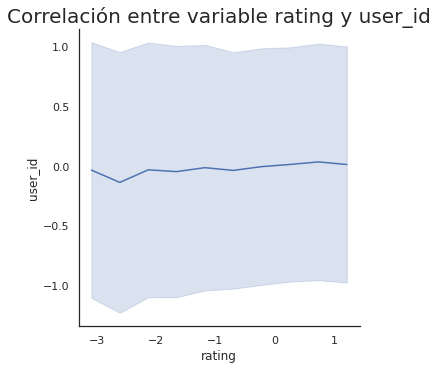

<Figure size 360x360 with 1 Axes>

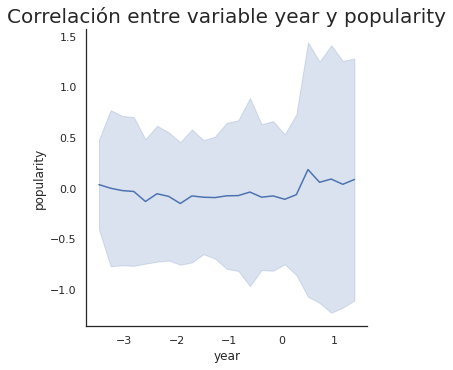

<Figure size 360x360 with 1 Axes>

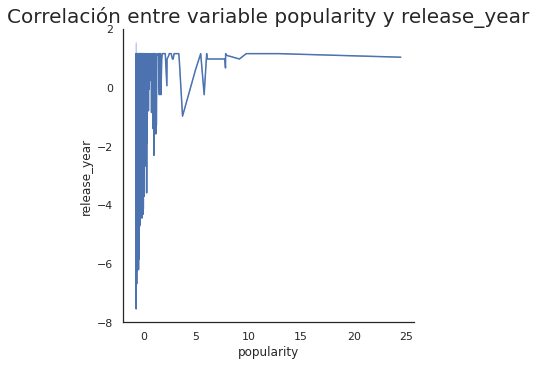

<Figure size 360x360 with 1 Axes>

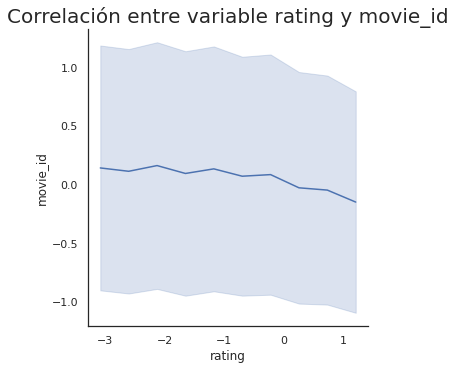

<Figure size 360x360 with 1 Axes>

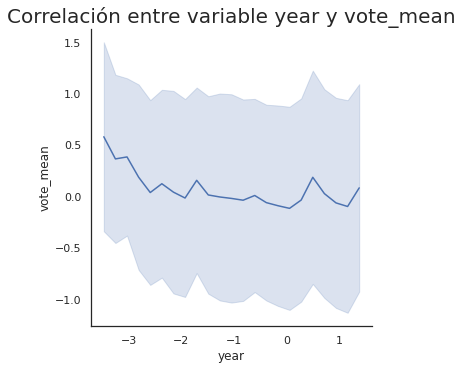

<Figure size 360x360 with 1 Axes>

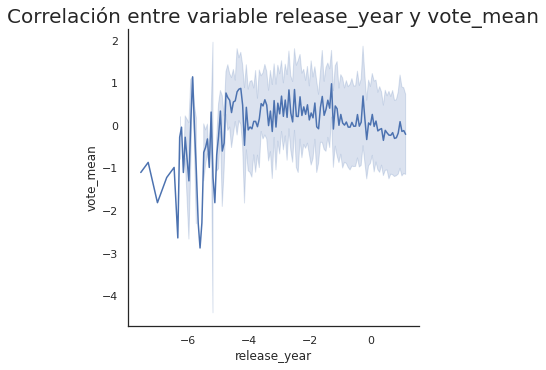

<Figure size 360x360 with 1 Axes>

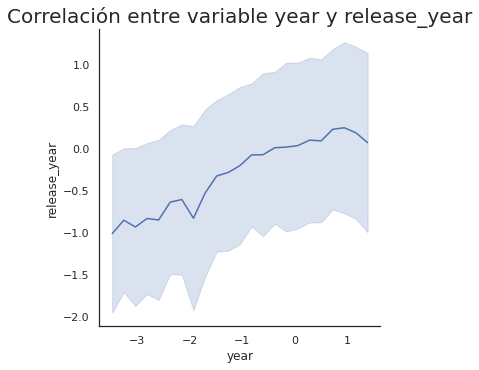

<Figure size 360x360 with 1 Axes>

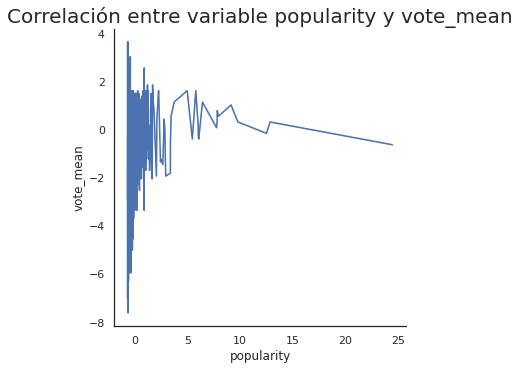

<Figure size 360x360 with 1 Axes>

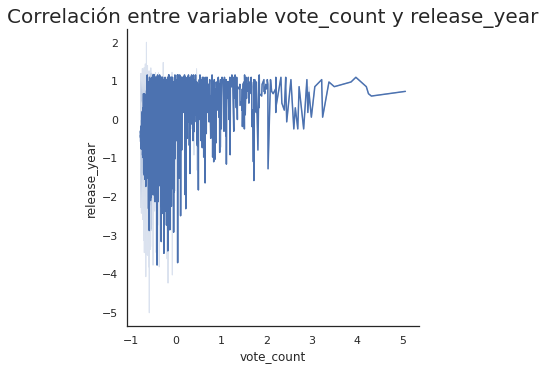

<Figure size 360x360 with 1 Axes>

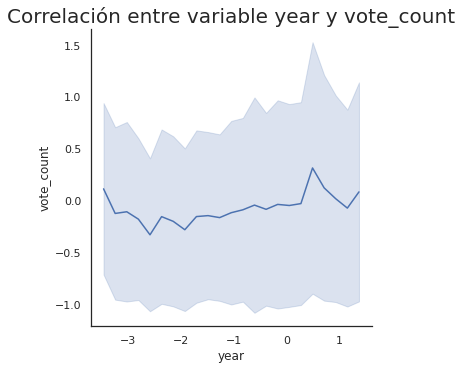

<Figure size 360x360 with 1 Axes>

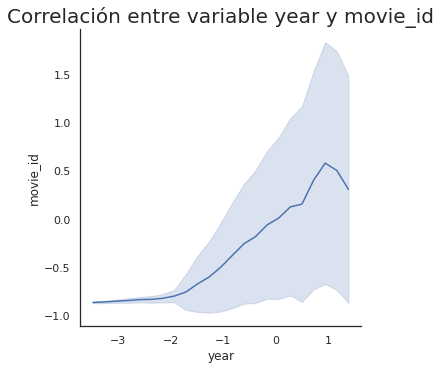

<Figure size 360x360 with 1 Axes>

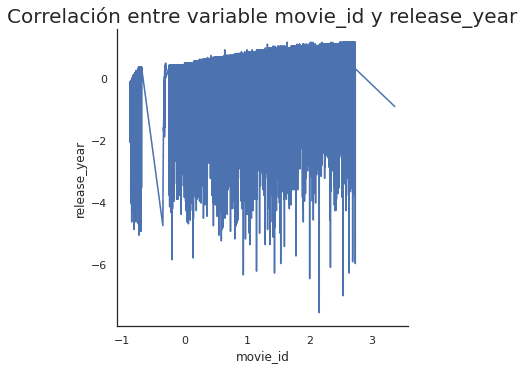

<Figure size 360x360 with 1 Axes>

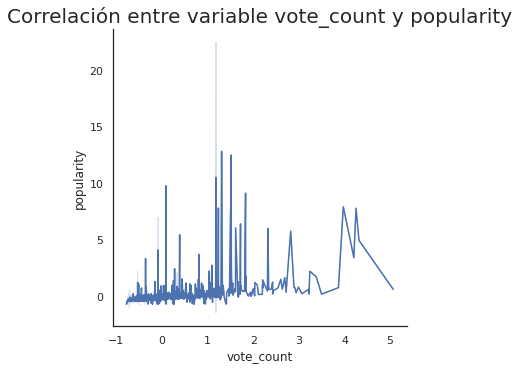

<Figure size 360x360 with 1 Axes>

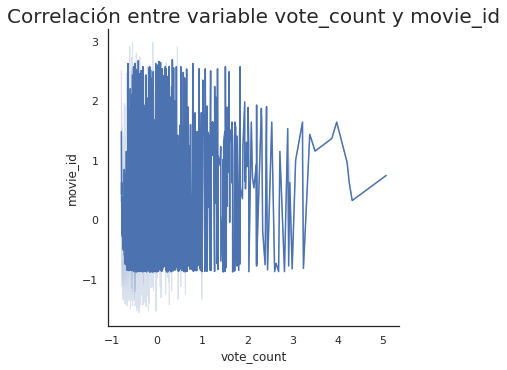

<Figure size 360x360 with 1 Axes>

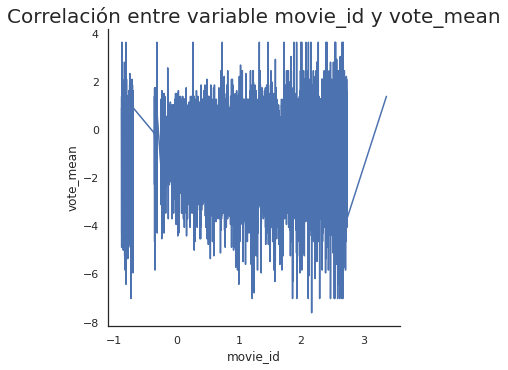

In [235]:
plot_correlations(norm_complete_num_data)

# Componentes Principales

In [527]:
clusters = {
    0.5: '<2',
    1.0: '<2',
    1.5: '<2',

    2.0: '2-3.5',
    2.5: '2-3.5',
    3.0: '2-3.5',
    3.5: '2-3.5',

    4.0: '>4',
    4.5: '>4',
    5.0: '>4'
}

colors = {
    0.5: 'red',
    1.0: 'red',
    1.5: 'red',

    2.0: 'green',
    2.5: 'green',
    3.0: 'green',
    3.5: 'green',

    4.0: 'yellow',
    4.5: 'yellow',
    5.0: 'yellow'
}



X  = norm_complete_num_data.copy().drop(columns=['rating'])
y  = complete_num_data.rating.apply(lambda x: clusters[x])

In [589]:
y.value_counts()

>4       114024
2-3.5     74732
<2        11035
Name: rating, dtype: int64

In [671]:
from sklearn import decomposition


from matplotlib import colors


class PCASummary:
    def __init__(self, pc, pca, y, n_components, columns):
        self.pc_columns          = [f'pc{i}'for i in range(1, n_components+1)]
        self.__observations      = pd.DataFrame(data = pc, columns = self.pc_columns)
        self.__observations['y'] = y
        self.pca                 = pca
        self.__columns           = columns

    def explained_variance(self):
        return self.pca.explained_variance_ratio_
    
    def plot_explained_variance(self):
        pl.barplot(
            data       = pd.DataFrame({
                'Variance': self.pca.explained_variance_ratio_,
                'Principal Components': self.pc_columns
            }),
            x          = 'Principal Components', 
            y          = 'Variance',
            x_rotation = 0
        )

    def plot_clusters(
        self, 
        pc_x       = 'pc1', 
        pc_y       = 'pc2',
        fit_reg    = False, 
        legend     = True,
        point_size = 40
    ):
        sns.lmplot(
            x           = pc_x, 
            y           = pc_y,
            data        = self.__observations, 
            fit_reg     = fit_reg, 
            hue         = 'y',
            legend      = legend,
            scatter_kws = { "s": point_size}
        )
        plt.show()
        
    def components(self, indexes=[0, 1]):
        return np.transpose(self.pca.components_[indexes, :])

    def observations(self, indexes=[1, 2]):
        return self.__observations[[f'pc{i}' for i in indexes]].values
    
    def biplot(
        self,
        comps      = [1, 2],
        labels     = None,
        s          = 100,
        alpha      = 0.2, 
        edgecolors = 'none'
    ):
        plt.style.use('ggplot')
        score  = self.observations(indexes=comps)
        coeff  = self.components()
        y      = self.__observations['y'].values
        labels = self.__columns
    
        xs = score[:,0]
        ys = score[:,1]

        n  = coeff.shape[0]

        scalex = 1.0/(xs.max() - xs.min())
        scaley = 1.0/(ys.max() - ys.min())

        fig, ax = plt.subplots()
        ax.scatter(
            xs * scalex,
            ys * scaley, 
            c          = pd.factorize(y)[0],
            s          = s,
            alpha      = alpha,
            edgecolors = edgecolors
        )
        ax.legend()
        ax.grid(True)

        for i in range(n):
            ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r', alpha = 0.8)
            if labels is None:
                ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
            else:
                ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.xlabel("PC{}".format(1))
        plt.ylabel("PC{}".format(2))

        plt.show()


class PCAAnalisys:
    @staticmethod
    def make_on(X, y, n_components=4):
        pca = decomposition.PCA(n_components=n_components)

        num_X = X.select_dtypes(include=np.number)        
        pc = pca.fit_transform(num_X.values)

        return PCASummary(pc, pca, y, n_components, X.columns)

In [672]:
summary = PCAAnalisys.make_on(X, y, n_components = 4)

In [673]:
summary.observations(indexes=[1,2])[:,0]

array([0.96954709, 0.15330365, 0.15188253, ..., 0.3015793 , 1.42605404,
       1.50269812])

<Figure size 360x360 with 1 Axes>

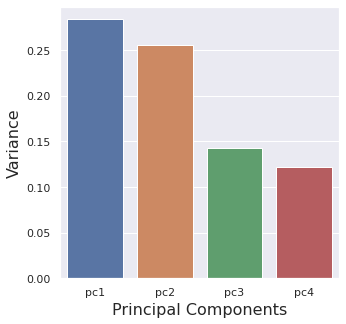

array([0.28330908, 0.25518806, 0.14245676, 0.12215638])

In [674]:
pl.s_size()
summary.plot_explained_variance()
summary.explained_variance()

2022-07-17 19:58:26,270 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1080x576 with 1 Axes>

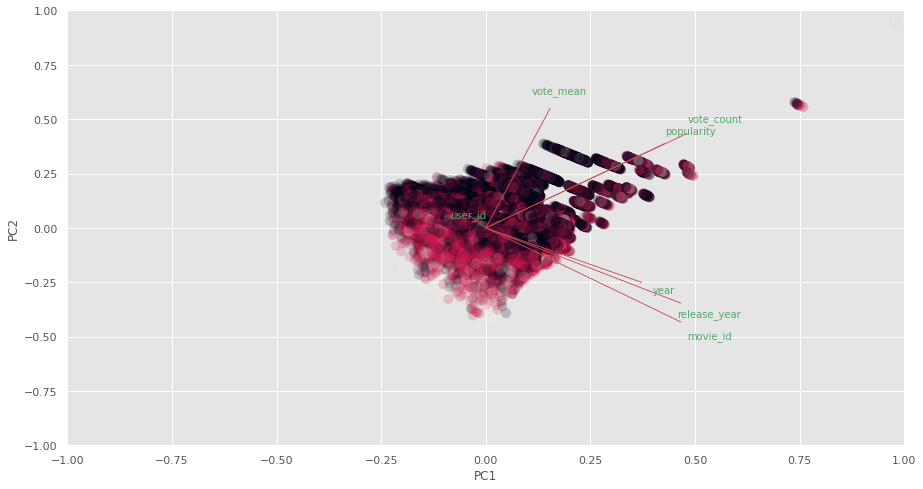

In [675]:
pl.l_size()
summary.biplot()

<Figure size 427.975x360 with 1 Axes>

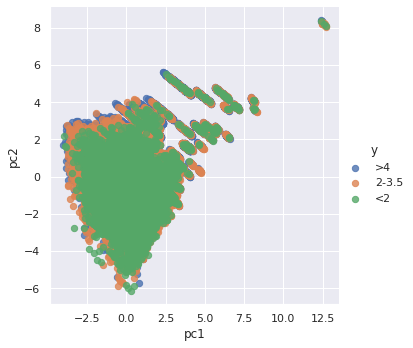

In [676]:
pl.l_size()
summary.plot_clusters()

## ¿Cuales son los generos de peliculas mas comunes?

In [ ]:
all_genres = lambda df: np.array([genre for genres in df['genres'].values for genre in genres])

genres_count = dt.frequency(all_genres(movies3),'genre')

pl.barplot(
    genres_count, 
    'genre', 
    'count', 
    figsize=(30, 6),
    x_rotation=45
)

## ¿Cuantas peliculas se estrenaron por año?

In [ ]:
yearly_release_counts = movies3 \
    .groupby(movies3.release.dt.year) \
    .size() \
    .sort_values(ascending=False) \
    .reset_index(name='count')

pl.barplot(
    yearly_release_counts[yearly_release_counts.release >= 1970], 
    'release', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

In [ ]:
pl.lineplot(
    yearly_release_counts, 
    'release', 
    'count', 
    figsize=(30, 6),
    x_rotation=45
)

## ¿Cuantas peliculas se estrenaron por mes?

In [ ]:
monthly_release_counts = movies3[movies3.release.dt.year >= 1970] \
    .groupby(movies3.release.dt.month) \
    .size() \
    .sort_values(ascending=False) \
    .reset_index(name='count')
    
monthly_release_counts['month'] = monthly_release_counts.release.apply(lambda it: dt.MONTHS[it-1])

pl.barplot(
    monthly_release_counts, 
    'month', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales son los dias de la seman preferidos para estrenar peliculas?

In [ ]:
weekday_release_counts = movies3[movies3.release.dt.year >= 1970] \
    .groupby(movies3.release.dt.dayofweek) \
    .size() \
    .reset_index(name='count')
    
weekday_release_counts['weekday'] = weekday_release_counts \
    .release.apply(lambda it: dt.WEEK[it-1])


pl.barplot(
    weekday_release_counts, 
    'weekday', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor presupuesto?

In [ ]:
data = movies \
    .sort_values(by=['budget'], ascending=False) \
    [['title', 'budget']] \
    [movies.budget > 0][:10]

pl.barplot(
    data, 
    'title', 
    'budget',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor popularidad?

In [ ]:
data = movies3 \
    .sort_values(by=['popularity'], ascending=False) \
    [['title', 'popularity']] \
    [movies3.popularity > 0][:10]

pl.barplot(
    data, 
    'title', 
    'popularity',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor promedio de votacion?

In [ ]:
data = movies3 \
    .sort_values(by=['vote_mean'], ascending=False) \
    [['title', 'vote_mean']] \
    [movies3.vote_mean > 0][:10]

pl.barplot(
    data, 
    'title', 
    'vote_mean',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor cantidad de votaciones?

In [ ]:
data = movies3 \
    .sort_values(by=['vote_count'], ascending=False) \
    [['title', 'vote_count']] \
    [movies3.vote_mean > 0][:10]

pl.barplot(
    data, 
    'title', 
    'vote_count',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor rating y votaciones?

In [ ]:
data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    ) \
    .sort_values(by=['rating', 'vote_count'], ascending=False) \
    [['title', 'rating', 'vote_count']] \
    .drop_duplicates() \
    [:10]

pl.barplot(
    data, 
    'title', 
    'vote_count',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor rating y popularidad?

In [ ]:
data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    ) \
    .sort_values(by=['rating', 'popularity'], ascending=False) \
    [['title', 'rating', 'popularity']] \
    .drop_duplicates() \
    [:10]

pl.barplot(
    data, 
    'title', 
    'popularity',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cual es la cantidad de peliculas estranada por año para cada genero?

In [ ]:
data = dt.list_column_to_dummy_columns(movies3, 'genres')

genres_columns = list(set(data.columns) - set(movies3.columns))

data = data[['release_year'] + genres_columns]

data = data[data['release_year'] <= 2013]


data = data[['release_year'] + genres_columns] \
    .groupby('release_year') \
    [genres_columns] \
    .sum() \
    .sort_values(by='release_year', ascending=True) \
    .reset_index()

[pl.lineplot(data, x='release_year', y=col, title=f'{col} release movies by year') for col in genres_columns]
None

In [ ]:
movies3.to_json(f'{DATASETS_PATH}/movies.json')
interactions.to_json(f'{DATASETS_PATH}/interactions.json')

### References

* https://www.kaggle.com/code/amar09/eda-recommendation-model-on-movielens-100k/notebook
* https://jovian.ai/surendranjagadeesh/movielens-eda